In [1]:
import os
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pickle
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [3]:
# Custom dataset class
class BreakHisDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label_name in ['benign', 'malignant']:
            label = 0 if label_name == 'benign' else 1
            class_dir = os.path.join(root_dir, label_name)
            for file_name in os.listdir(class_dir):
                if file_name.lower().endswith('.png'):
                    path = os.path.join(class_dir, file_name)
                    self.samples.append((path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, path


In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Set paths
train_dir = "/content/drive/MyDrive/ICAN/breakhis_pytorch/train"
val_dir = "/content/drive/MyDrive/ICAN/breakhis_pytorch/val"

# Create datasets
train_dataset = BreakHisDataset(train_dir, transform=transform)
val_dataset = BreakHisDataset(val_dir, transform=transform)

In [5]:
from collections import Counter

# Fast label counting: skip transform and image loading
def count_labels(dataset):
    counter = Counter()
    for i in range(len(dataset)):
        _, label = dataset.samples[i]  # no transform or open
        counter[label] += 1
    return counter

# Use existing train_dataset and val_dataset (already defined)
train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)

print("Train Set:")
print(f"  Benign (0):    {train_counts[0]}")
print(f"  Malignant (1): {train_counts[1]}")
print(f"  Total:         {sum(train_counts.values())}")

print("\nValidation Set:")
print(f"  Benign (0):    {val_counts[0]}")
print(f"  Malignant (1): {val_counts[1]}")
print(f"  Total:         {sum(val_counts.values())}")


Train Set:
  Benign (0):    1923
  Malignant (1): 3800
  Total:         5723

Validation Set:
  Benign (0):    1206
  Malignant (1): 1629
  Total:         2835


In [6]:
best_val_loss = float('inf')
patience = 3
epochs_no_improve = 0
max_epochs = 10

In [7]:
# Create loaders for the models. Change batch size and workers based on need
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=6, pin_memory=True)

# Set the Traing and Validation Loader

In [8]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []
    for images, labels, _ in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return avg_loss, acc, prec, rec, f1

In [9]:
def evaluate(model, loader):
    model.eval()
    running_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _ in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return avg_loss, acc, prec, rec, f1


# **CNN**

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # -> [64, 56, 56]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)



In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = SimpleCNN().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [ ]:
best_val_loss = float('inf')
patience = 3
epochs_no_improve = 0
max_epochs = 10

cnn_train_log = []
cnn_val_log = []

for epoch in range(1, max_epochs + 1):
    print(f"\nEpoch {epoch}")

    train_stats = train_one_epoch(cnn_model, train_loader)
    val_stats = evaluate(cnn_model, val_loader)

    cnn_train_log.append(train_stats)
    cnn_val_log.append(val_stats)

    print(f"Train Loss: {train_stats[0]:.4f} | Acc: {train_stats[1]:.4f} | F1: {train_stats[4]:.4f}")
    print(f"Val   Loss: {val_stats[0]:.4f} | Acc: {val_stats[1]:.4f} | F1: {val_stats[4]:.4f}")

    current_val_loss = val_stats[0]
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        epochs_no_improve = 0
        best_model_state = cnn_model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch} — no improvement for {patience} epochs.")
            break


Epoch 1


Training: 100%|██████████| 23/23 [12:34<00:00, 32.82s/it]


Train Loss: 2.6235 | Acc: 0.6175 | F1: 0.7500
Val   Loss: 0.8183 | Acc: 0.5746 | F1: 0.7298

Epoch 2


Training: 100%|██████████| 23/23 [00:24<00:00,  1.08s/it]


Train Loss: 0.5889 | Acc: 0.6640 | F1: 0.7981
Val   Loss: 0.6084 | Acc: 0.5746 | F1: 0.7298

Epoch 3


Training: 100%|██████████| 23/23 [00:24<00:00,  1.07s/it]


Train Loss: 0.5427 | Acc: 0.7229 | F1: 0.8155
Val   Loss: 0.5907 | Acc: 0.7104 | F1: 0.7955

Epoch 4


Training: 100%|██████████| 23/23 [00:24<00:00,  1.08s/it]


Train Loss: 0.5052 | Acc: 0.7863 | F1: 0.8503
Val   Loss: 0.4880 | Acc: 0.7788 | F1: 0.8015

Epoch 5


Training: 100%|██████████| 23/23 [00:24<00:00,  1.06s/it]


Train Loss: 0.4633 | Acc: 0.8167 | F1: 0.8685
Val   Loss: 0.5068 | Acc: 0.7859 | F1: 0.8386

Epoch 6


Training: 100%|██████████| 23/23 [00:24<00:00,  1.06s/it]


Train Loss: 0.4294 | Acc: 0.8293 | F1: 0.8781
Val   Loss: 0.4336 | Acc: 0.8272 | F1: 0.8581

Epoch 7


Training: 100%|██████████| 23/23 [00:24<00:00,  1.06s/it]


Train Loss: 0.4096 | Acc: 0.8363 | F1: 0.8826
Val   Loss: 0.4238 | Acc: 0.8212 | F1: 0.8568

Epoch 8


Training: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Train Loss: 0.4283 | Acc: 0.8270 | F1: 0.8760
Val   Loss: 0.4500 | Acc: 0.8155 | F1: 0.8551

Epoch 9


Training: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Train Loss: 0.3903 | Acc: 0.8457 | F1: 0.8888
Val   Loss: 0.4021 | Acc: 0.8310 | F1: 0.8620

Epoch 10


Training: 100%|██████████| 23/23 [00:24<00:00,  1.06s/it]


Train Loss: 0.3849 | Acc: 0.8482 | F1: 0.8906
Val   Loss: 0.4137 | Acc: 0.8222 | F1: 0.8591


In [ ]:
# === Evaluate ViT-B/16 on validation set ===
cnn_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, _ in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Classification metrics ===
report = classification_report(
    all_labels,
    all_preds,
    target_names=["Benign", "Malignant"],
    output_dict=True
)

vit_metrics = {
    "Accuracy": report["accuracy"],
    "Precision": report["weighted avg"]["precision"],
    "Recall": report["weighted avg"]["recall"],
    "F1 Score": report["weighted avg"]["f1-score"],
    "Loss": sum(x[0] for x in cnn_val_log) / len(cnn_val_log)
}

# Print metrics
print("CNN Performance Metrics")
for k, v in vit_metrics.items():
    print(f"{k:<10}: {v:.4f}")

CNN Performance Metrics
Accuracy  : 0.8222
Precision : 0.8344
Recall    : 0.8222
F1 Score  : 0.8166
Loss      : 0.5135


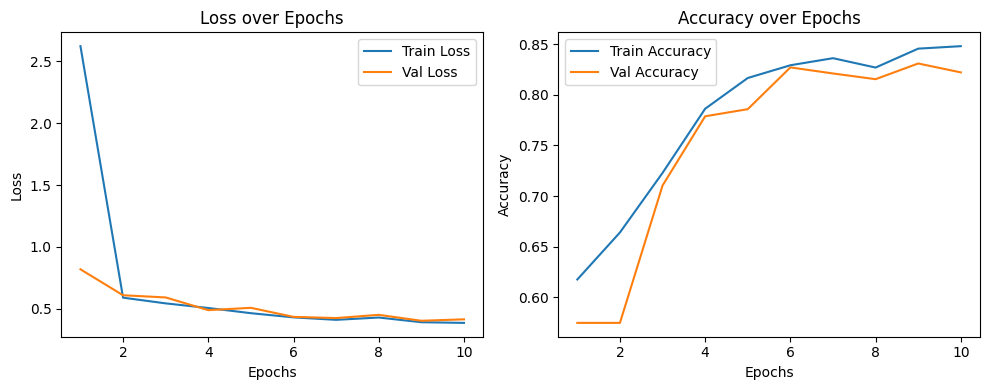

In [ ]:
import matplotlib.pyplot as plt

# Separate values for plotting
train_loss = [x[0] for x in cnn_train_log]
val_loss = [x[0] for x in cnn_val_log]
train_acc = [x[1] for x in cnn_train_log]
val_acc = [x[1] for x in cnn_val_log]

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


# ViT-B/16

In [18]:
# Load pretrained ViT-B/16
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Replace classifier head for 2 classes
vit.heads.head = nn.Linear(vit.heads.head.in_features, 2)

# Send to GPU
vit = vit.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 229MB/s]


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=0.0001)  # smaller LR for pretrained
vit_train_log = []
vit_val_log = []

In [ ]:
best_val_loss = float('inf')
patience = 3
epochs_no_improve = 0
max_epochs = 10

vit_train_log = []
vit_val_log = []

for epoch in range(1, max_epochs + 1):
    print(f"\nEpoch {epoch}")

    train_stats = train_one_epoch(vit, train_loader)
    val_stats = evaluate(vit, val_loader)

    vit_train_log.append(train_stats)
    vit_val_log.append(val_stats)

    print(f"Train Loss: {train_stats[0]:.4f} | Acc: {train_stats[1]:.4f} | F1: {train_stats[4]:.4f}")
    print(f"Val   Loss: {val_stats[0]:.4f} | Acc: {val_stats[1]:.4f} | F1: {val_stats[4]:.4f}")

    current_val_loss = val_stats[0]
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        epochs_no_improve = 0
        best_model_state = vit.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch} — no improvement for {patience} epochs.")
            break



Epoch 1


Training: 100%|██████████| 45/45 [08:57<00:00, 11.95s/it]


Train Loss: 0.6478 | Acc: 0.6593 | F1: 0.7835
Val   Loss: 0.5199 | Acc: 0.7280 | F1: 0.7371

Epoch 2


Training: 100%|██████████| 45/45 [01:29<00:00,  1.98s/it]


Train Loss: 0.4849 | Acc: 0.7873 | F1: 0.8472
Val   Loss: 0.3760 | Acc: 0.8533 | F1: 0.8800

Epoch 3


Training: 100%|██████████| 45/45 [01:32<00:00,  2.06s/it]


Train Loss: 0.3368 | Acc: 0.8613 | F1: 0.8990
Val   Loss: 0.1754 | Acc: 0.9291 | F1: 0.9386

Epoch 4


Training: 100%|██████████| 45/45 [01:33<00:00,  2.07s/it]


Train Loss: 0.5069 | Acc: 0.7812 | F1: 0.8458
Val   Loss: 0.4477 | Acc: 0.8148 | F1: 0.8432

Epoch 5


Training: 100%|██████████| 45/45 [01:33<00:00,  2.08s/it]


Train Loss: 0.4485 | Acc: 0.8043 | F1: 0.8609
Val   Loss: 0.4388 | Acc: 0.8042 | F1: 0.8519

Epoch 6


Training: 100%|██████████| 45/45 [01:33<00:00,  2.09s/it]


Train Loss: 0.3600 | Acc: 0.8499 | F1: 0.8910
Val   Loss: 0.3589 | Acc: 0.8356 | F1: 0.8499

Early stopping at epoch 6 — no improvement for 3 epochs.


In [ ]:
# === Evaluate ViT-B/16 on validation set ===
vit.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, _ in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Classification metrics ===
report = classification_report(
    all_labels,
    all_preds,
    target_names=["Benign", "Malignant"],
    output_dict=True
)

vit_metrics = {
    "Accuracy": report["accuracy"],
    "Precision": report["weighted avg"]["precision"],
    "Recall": report["weighted avg"]["recall"],
    "F1 Score": report["weighted avg"]["f1-score"],
    "Loss": sum(x[0] for x in vit_val_log) / len(vit_val_log)
}

# Print metrics
print("ViT-B/16 Performance Metrics")
for k, v in vit_metrics.items():
    print(f"{k:<10}: {v:.4f}")

ViT-B/16 Performance Metrics
Accuracy  : 0.8356
Precision : 0.8423
Recall    : 0.8356
F1 Score  : 0.8365
Loss      : 0.3861


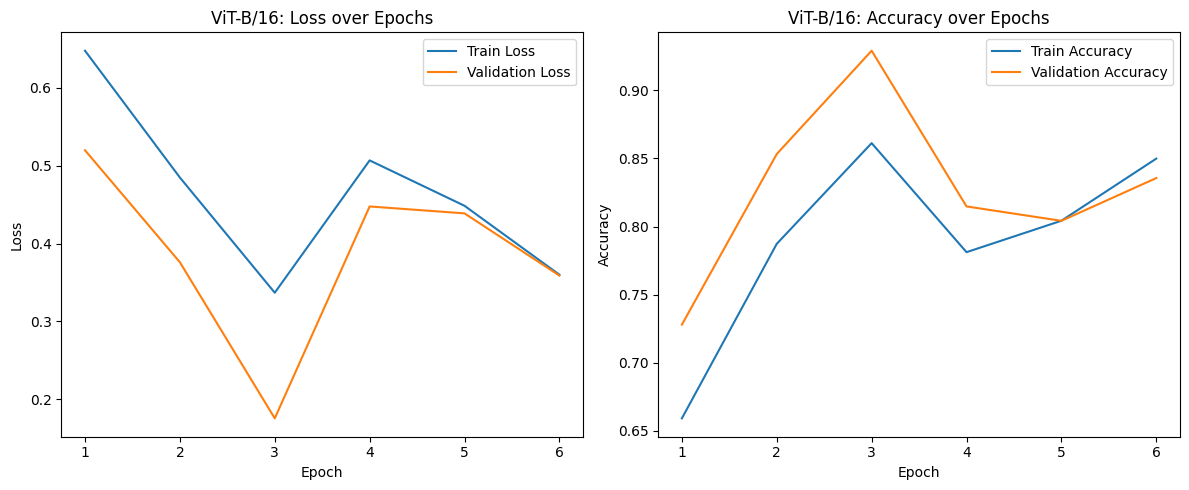

In [ ]:
import matplotlib.pyplot as plt
# Extract metrics from logs
epochs = list(range(1, len(vit_train_log) + 1))
train_acc = [x[1] for x in vit_train_log]
val_acc = [x[1] for x in vit_val_log]
train_loss = [x[0] for x in vit_train_log]
val_loss = [x[0] for x in vit_val_log]

# Plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ViT-B/16: Loss over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ViT-B/16: Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


# ViT-CNN

In [21]:
import torch
import torch.nn as nn
from torchvision import models

class ViTCNNFusion(nn.Module):
    def __init__(self):
        super(ViTCNNFusion, self).__init__()

        # --- CNN Branch ---
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 224x224 → 224x224
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 224x224 → 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 112x112 → 112x112
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 112x112 → 56x56
        )
        self.cnn_flatten = nn.Flatten()
        self.cnn_fc = nn.Linear(64 * 56 * 56, 512)

        # --- ViT Branch ---
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        self.vit.heads.head = nn.Identity()  # remove classifier, keep embeddings

        # --- Fusion ---
        self.fusion = nn.Sequential(
            nn.Linear(512 + 768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        # CNN branch
        cnn_feat = self.cnn(x)
        cnn_feat = self.cnn_flatten(cnn_feat)
        cnn_feat = self.cnn_fc(cnn_feat)

        # ViT branch
        vit_feat = self.vit(x)

        # Concatenate features
        combined = torch.cat((cnn_feat, vit_feat), dim=1)

        # Classify
        out = self.fusion(combined)
        return out


In [22]:
# Reinitialize model
fusion_model = ViTCNNFusion().to(device)

# Reset optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.0001)

# Reset logs
fusion_train_log = []
fusion_val_log = []



In [ ]:
fusion_train_log = []
fusion_val_log = []

best_val_loss = float('inf')
patience = 3
epochs_no_improve = 0
max_epochs = 10

for epoch in range(1, max_epochs + 1):
    print(f"\nEpoch {epoch}")

    train_stats = train_one_epoch(fusion_model, train_loader)
    val_stats = evaluate(fusion_model, val_loader)

    fusion_train_log.append(train_stats)
    fusion_val_log.append(val_stats)

    print(f"Train Loss: {train_stats[0]:.4f} | Acc: {train_stats[1]:.4f} | F1: {train_stats[4]:.4f}")
    print(f"Val   Loss: {val_stats[0]:.4f} | Acc: {val_stats[1]:.4f} | F1: {val_stats[4]:.4f}")

    # Early stopping check
    current_val_loss = val_stats[0]
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        epochs_no_improve = 0
        best_model_state = fusion_model.state_dict()  # optional: save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch} — no improvement for {patience} epochs.")
            break


Epoch 1


Training: 100%|██████████| 90/90 [13:35<00:00,  9.06s/it]


Train Loss: 0.5489 | Acc: 0.7314 | F1: 0.8115
Val   Loss: 0.4204 | Acc: 0.8399 | F1: 0.8725

Epoch 2


Training: 100%|██████████| 90/90 [01:39<00:00,  1.11s/it]


Train Loss: 0.3658 | Acc: 0.8389 | F1: 0.8815
Val   Loss: 0.2231 | Acc: 0.9122 | F1: 0.9249

Epoch 3


Training: 100%|██████████| 90/90 [01:39<00:00,  1.11s/it]


Train Loss: 0.1949 | Acc: 0.9261 | F1: 0.9446
Val   Loss: 0.2056 | Acc: 0.9199 | F1: 0.9254

Epoch 4


Training: 100%|██████████| 90/90 [01:39<00:00,  1.11s/it]


Train Loss: 0.1105 | Acc: 0.9589 | F1: 0.9691
Val   Loss: 0.1458 | Acc: 0.9453 | F1: 0.9543

Epoch 5


Training: 100%|██████████| 90/90 [01:39<00:00,  1.11s/it]


Train Loss: 0.0639 | Acc: 0.9787 | F1: 0.9839
Val   Loss: 0.0905 | Acc: 0.9707 | F1: 0.9743

Epoch 6


Training: 100%|██████████| 90/90 [01:39<00:00,  1.11s/it]


Train Loss: 0.0596 | Acc: 0.9783 | F1: 0.9837
Val   Loss: 0.0908 | Acc: 0.9672 | F1: 0.9718

Epoch 7


Training: 100%|██████████| 90/90 [01:39<00:00,  1.11s/it]


Train Loss: 0.0512 | Acc: 0.9797 | F1: 0.9847
Val   Loss: 0.1105 | Acc: 0.9616 | F1: 0.9659

Epoch 8


Training: 100%|██████████| 90/90 [01:39<00:00,  1.11s/it]


Train Loss: 0.0328 | Acc: 0.9881 | F1: 0.9911
Val   Loss: 0.1082 | Acc: 0.9683 | F1: 0.9717

Early stopping at epoch 8 — no improvement for 3 epochs.


In [ ]:
# === Evaluate on validation set ===
fusion_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, _ in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = fusion_model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Classification report ===
report = classification_report(
    all_labels, all_preds,
    target_names=["Benign", "Malignant"],
    output_dict=True
)

fusion_metrics = {
    "Accuracy": report["accuracy"],
    "Precision": report["weighted avg"]["precision"],
    "Recall": report["weighted avg"]["recall"],
    "F1 Score": report["weighted avg"]["f1-score"],
    "Loss": sum([x[0] for x in fusion_val_log]) / len(fusion_val_log)
}

# === Print results ===
print("ViT+CNN Fusion Performance Metrics")
for k, v in fusion_metrics.items():
    print(f"{k:<10}: {v:.4f}")

ViT+CNN Fusion Performance Metrics
Accuracy  : 0.9683
Precision : 0.9698
Recall    : 0.9683
F1 Score  : 0.9684
Loss      : 0.1744


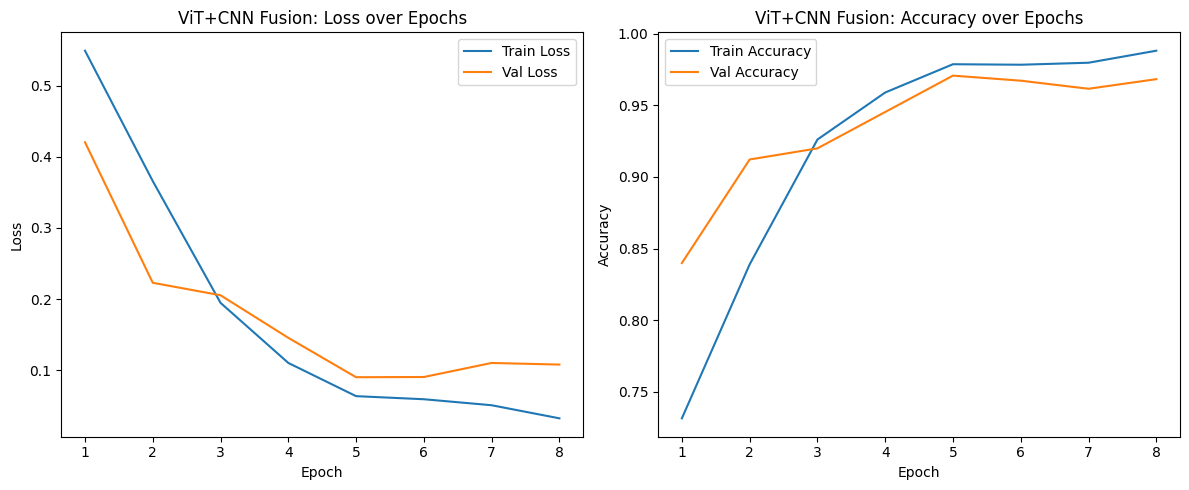

In [ ]:
import matplotlib.pyplot as plt

# === Plot Accuracy and Loss ===
epochs = list(range(1, len(fusion_train_log) + 1))
train_acc = [x[1] for x in fusion_train_log]
val_acc = [x[1] for x in fusion_val_log]
train_loss = [x[0] for x in fusion_train_log]
val_loss = [x[0] for x in fusion_val_log]

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ViT+CNN Fusion: Loss over Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ViT+CNN Fusion: Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# GRADCAM

In [ ]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [ ]:
target_layer = fusion_model.cnn[-2]  # Last conv layer (before MaxPool2d)
cam_extractor = GradCAM(model=fusion_model.cnn, target_layer=target_layer)


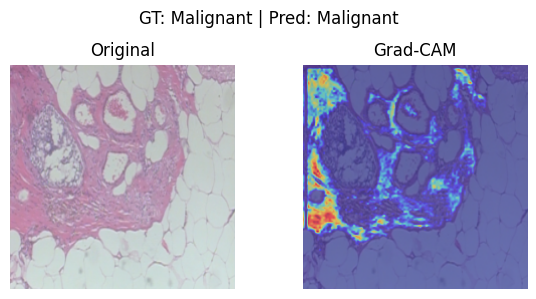

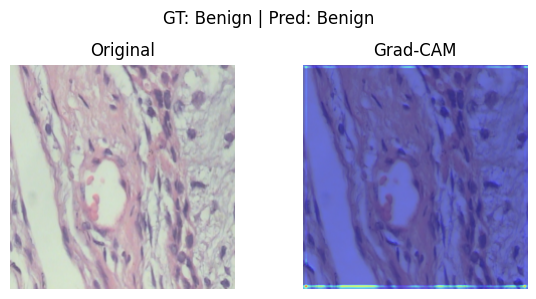

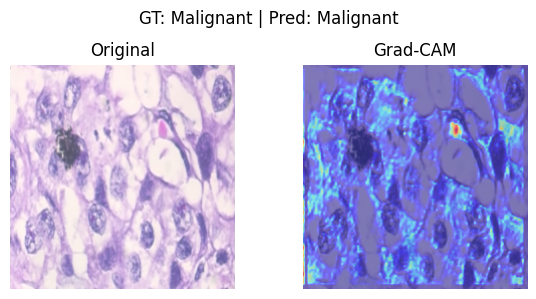

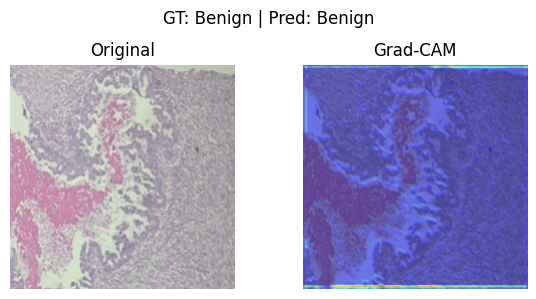

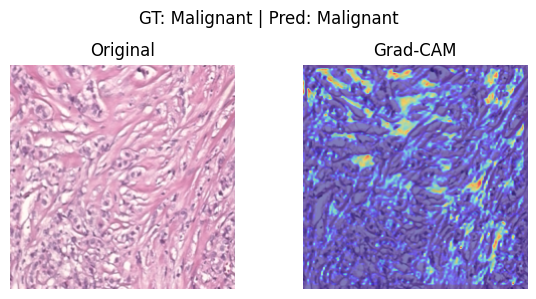

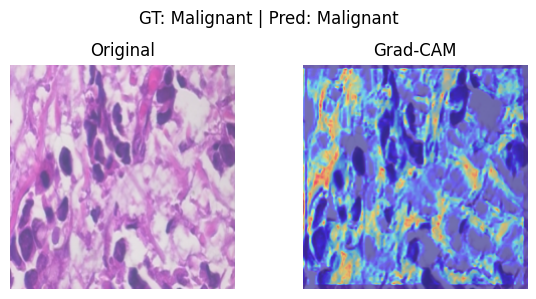

In [ ]:
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask
import numpy as np
import matplotlib.pyplot as plt

fusion_model.eval()

# Pick 6 random validation indices instead of 5
indices = np.random.choice(len(val_dataset), 6, replace=False)

for i, idx in enumerate(indices):
    image, label, path = val_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    # Forward pass and predicted class
    output = fusion_model(input_tensor)
    pred_class = output.argmax().item()

    # Grad-CAM for predicted class
    cam = cam_extractor(class_idx=pred_class, scores=output)[0].cpu()

    # Visuals
    original_img = to_pil_image(image)
    result = overlay_mask(original_img, to_pil_image(cam, mode='F'), alpha=0.5)

    class_names = {0: "Benign", 1: "Malignant"}

    # Plot side by side
    plt.figure(figsize=(6, 3))
    plt.suptitle(f"GT: {class_names[label]} | Pred: {class_names[pred_class]}")

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Benchmarking

In [10]:
import torch
import time
import psutil
import platform
import gc
import numpy as np

def benchmark_model(model, dataloader, device_name="cpu", label="", max_batches=10):
    torch.cuda.empty_cache()
    gc.collect()

    device = torch.device(device_name)
    model = model.to(device)
    model.eval()

    times = []
    mem_usage = []

    process = psutil.Process()

    with torch.no_grad():
        for i, (images, _, _) in enumerate(dataloader):
            if i >= max_batches:
                break

            images = images.to(device)

            torch.cuda.synchronize() if device_name == "cuda" else None
            start = time.time()
            _ = model(images)
            torch.cuda.synchronize() if device_name == "cuda" else None
            end = time.time()

            times.append(end - start)
            mem = process.memory_info().rss / (1024 ** 2)  # MB
            mem_usage.append(mem)

    avg_latency = np.mean(times) / len(images)
    fps = 1 / avg_latency
    avg_mem = np.mean(mem_usage)

    return {
        "Model": label,
        "Device": device_name,
        "Latency (s/img)": round(avg_latency, 5),
        "FPS": round(fps, 2),
        "Memory (MB)": round(avg_mem, 2),
        "Platform": platform.machine()
    }


In [11]:
# Simulate edge by limiting CPU threads
torch.set_num_threads(1)

# Small batch size for low-resource simulation
edge_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)


In [23]:
results = []

# Full-resource loaders
standard_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# Benchmark CNN
results.append(benchmark_model(cnn_model, standard_loader, "cpu", "CNN (CPU)"))
results.append(benchmark_model(cnn_model, standard_loader, "cuda", "CNN (GPU)"))
results.append(benchmark_model(cnn_model, edge_loader, "cuda", "CNN (GPU-Edge)"))
results.append(benchmark_model(cnn_model, edge_loader, "cpu", "CNN (CPU-Edge)"))

# Benchmark ViT
results.append(benchmark_model(vit, standard_loader, "cpu", "ViT (CPU)"))
results.append(benchmark_model(vit, standard_loader, "cuda", "ViT (GPU)"))
results.append(benchmark_model(vit, edge_loader, "cuda", "ViT (GPU-Edge)"))
results.append(benchmark_model(vit, edge_loader, "cpu", "ViT (CPU-Edge)"))

# Benchmark ViT+CNN
results.append(benchmark_model(fusion_model, standard_loader, "cpu", "ViT+CNN (CPU)"))
results.append(benchmark_model(fusion_model, standard_loader, "cuda", "ViT+CNN (GPU)"))
results.append(benchmark_model(fusion_model, edge_loader, "cuda", "ViT+CNN (GPU-Edge)"))
results.append(benchmark_model(fusion_model, edge_loader, "cpu", "ViT+CNN (CPU-Edge)"))


In [25]:
import pandas as pd
df_benchmark = pd.DataFrame(results)
df_benchmark = df_benchmark.sort_values(by=["Model"])
df_benchmark.reset_index(drop=True, inplace=True)
df_benchmark


,Model,Device,Latency (s/img),FPS,Memory (MB),Platform
0,CNN (CPU),cpu,0.04474,22.35,1366.45,x86_64
1,CNN (CPU-Edge),cpu,0.04040,24.75,1449.80,x86_64
2,CNN (GPU),cuda,0.00697,143.57,1227.55,x86_64
3,CNN (GPU-Edge),cuda,0.00804,124.39,1252.71,x86_64
4,ViT (CPU),cpu,0.36905,2.71,1776.78,x86_64
5,ViT (CPU-Edge),cpu,0.37958,2.63,1932.95,x86_64
6,ViT (GPU),cuda,0.00429,233.32,1777.69,x86_64
7,ViT (GPU-Edge),cuda,0.00912,109.61,1779.59,x86_64
8,ViT+CNN (CPU),cpu,0.41611,2.40,2558.84,x86_64
9,ViT+CNN (CPU-Edge),cpu,0.42706,2.34,2560.14,x86_64
